## Celda 1: Instalación de dependencias

In [1]:
# Instalar paquetes necesarios
!pip install optuna lightgbm --quiet

## Celda 2: Importaciones

In [2]:
import os
import json
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error

import optuna
import lightgbm as lgb

/home/miguel/Documentos/utn/sube_prediction/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Celda 3: Carga de datos

In [3]:
# Carga de datos desde Google Drive
import requests
from io import StringIO
file_id = '16RsfvTFOJciZmP4JUAfSLtlxcDFcz6Ch'
url_datos = f'https://drive.google.com/uc?export=download&id={file_id}'
try:
    print("Descargando datos desde Google Drive...")
    response = requests.get(url_datos)
    response.raise_for_status()
    data = StringIO(response.text)
    df = pd.read_csv(data, delimiter=',', header=0)
    print("¡Datos cargados correctamente!")
except Exception as e:
    print(f"Error al cargar los datos desde Drive: {e}")
    # Alternativa: montar Drive si la descarga directa falla
    # from google.colab import drive
    # drive.mount('/content/drive')
    # df = pd.read_csv('/content/drive/MyDrive/transporte_datos.csv', parse_dates=['Dia'])
df.head()

Descargando datos desde Google Drive...
¡Datos cargados correctamente!


,Dia,Cantidad,Linea,Nombre_Empresa,Provincia,Municipio,Temp_media,Temp_max,Temp_min,Lluvia_Binaria,Precip_Total,Humedad_Media,Vel_Prom_Viento,Condicion_Cielo,Dia_Semana,Feriado
0,2020-01-01,119,LINEA 110,SOCIEDAD DE TRANSPORTE DE MENDOZA SOCIEDAD ANO...,MENDOZA,SN,28.333333,31.0,24.5,0,0.0,40.083333,17.441667,0.0,Wednesday,1
1,2020-01-01,54,LINEA 121,SOCIEDAD DE TRANSPORTE DE MENDOZA SOCIEDAD ANO...,MENDOZA,SN,28.333333,31.0,24.5,0,0.0,40.083333,17.441667,0.0,Wednesday,1
2,2020-01-01,21,LINEA 126,SOCIEDAD DE TRANSPORTE DE MENDOZA SOCIEDAD ANO...,MENDOZA,SN,28.333333,31.0,24.5,0,0.0,40.083333,17.441667,0.0,Wednesday,1
3,2020-01-01,19,LINEA 130,SOCIEDAD DE TRANSPORTE DE MENDOZA SOCIEDAD ANO...,MENDOZA,SN,28.333333,31.0,24.5,0,0.0,40.083333,17.441667,0.0,Wednesday,1
4,2020-01-01,83,LINEA 200,EMPRESA MAIPU S.R.L.,MENDOZA,SN,28.333333,31.0,24.5,0,0.0,40.083333,17.441667,0.0,Wednesday,1


## Celda 4: Limpieza y Feature Engineering

In [4]:
df['Dia'] = pd.to_datetime(df['Dia'])
df['Condicion_Cielo'] = df['Condicion_Cielo'].fillna(-1).astype(int)

codigos_cielo = {
    1: "Despejado", 2: "Poco nuboso", 3: "Nublado", 4: "Cubierto", 5: "Niebla", 6: "Niebla helada",
    7: "Lluvia ligera", 8: "Lluvia", 9: "Lluvia intensa", 10: "Lluvia helada", 11: "Lluvia helada intensa",
    12: "Aguanieve", 13: "Aguanieve intensa", 14: "Nevada ligera", 15: "Nevada", 16: "Nevada intensa",
    17: "Lluvia pasajera", 18: "Lluvia pasajera intensa", 19: "Aguanieve pasajera", 20: "Aguanieve pasajera intensa",
    21: "Nevada pasajera", 22: "Nevada pasajera intensa", 23: "Relámpagos", 24: "Granizo", 25: "Tormenta eléctrica",
    26: "Tormenta eléctrica intensa", 27: "Tormenta", -1: "Desconocido"
}
df['Condicion_Cielo_Nombre'] = df['Condicion_Cielo'].map(codigos_cielo)
condiciones_adversas = [
    'Lluvia', 'Lluvia ligera', 'Lluvia intensa', 'Niebla', 'Niebla helada',
    'Lluvia helada', 'Lluvia helada intensa', 'Tormenta eléctrica', 'Tormenta eléctrica intensa', 'Tormenta'
]
df['Condicion_Adversa'] = df['Condicion_Cielo_Nombre'].isin(condiciones_adversas).astype(int)
df['Mes'] = df['Dia'].dt.month
df['Anio'] = df['Dia'].dt.year
df['Dia_Mes'] = df['Dia'].dt.day
df['Es_FinDeSemana'] = df['Dia_Semana'].isin(['Saturday', 'Sunday']).astype(int)
df['Temp_Templada'] = df['Temp_media'].between(8,28).astype(int)
df['Temp_Extrema'] = ((df['Temp_media'] < 8) | (df['Temp_media'] > 28)).astype(int)
df['Adversa_Finde'] = df['Condicion_Adversa'] * df['Es_FinDeSemana']
df['Feriado_TempExtrema'] = df['Feriado'] * df['Temp_Extrema']

# Lags y medias móviles por línea
df = df.sort_values(['Linea','Dia'])
df['Cantidad_lag_1'] = df.groupby('Linea')['Cantidad'].shift(1)
df['Cantidad_lag_7'] = df.groupby('Linea')['Cantidad'].shift(7)
df['Cantidad_ma_7'] = df.groupby('Linea')['Cantidad'].transform(lambda x: x.rolling(7, min_periods=1).mean())
df['Cantidad_lag_1'] = df.groupby('Linea')['Cantidad_lag_1'].transform(lambda x: x.fillna(x.mean()))
df['Cantidad_lag_7'] = df.groupby('Linea')['Cantidad_lag_7'].transform(lambda x: x.fillna(x.mean()))
df = df.reset_index(drop=True)
df.head()

,Dia,Cantidad,Linea,Nombre_Empresa,Provincia,Municipio,Temp_media,Temp_max,Temp_min,Lluvia_Binaria,...,Anio,Dia_Mes,Es_FinDeSemana,Temp_Templada,Temp_Extrema,Adversa_Finde,Feriado_TempExtrema,Cantidad_lag_1,Cantidad_lag_7,Cantidad_ma_7
0,2020-01-10,1,LINEA 100,SOCIEDAD DE TRANSPORTE DE MENDOZA SOCIEDAD ANO...,MENDOZA,SN,25.216667,29.7,21.2,0,...,2020,10,0,1,0,0,0,8254.934243,8255.410357,1.000000
1,2020-01-14,86,LINEA 100,SOCIEDAD DE TRANSPORTE DE MENDOZA SOCIEDAD ANO...,MENDOZA,SN,26.979167,32.6,22.0,0,...,2020,14,0,1,0,0,0,1.000000,8255.410357,43.500000
2,2020-01-15,161,LINEA 100,SOCIEDAD DE TRANSPORTE DE MENDOZA SOCIEDAD ANO...,MENDOZA,SN,25.400000,30.7,20.6,0,...,2020,15,0,1,0,0,0,86.000000,8255.410357,82.666667
3,2020-01-16,229,LINEA 100,SOCIEDAD DE TRANSPORTE DE MENDOZA SOCIEDAD ANO...,MENDOZA,SN,22.666667,27.5,18.0,0,...,2020,16,0,1,0,0,0,161.000000,8255.410357,119.250000
4,2020-01-17,519,LINEA 100,SOCIEDAD DE TRANSPORTE DE MENDOZA SOCIEDAD ANO...,MENDOZA,SN,24.350000,32.1,18.0,0,...,2020,17,0,1,0,0,0,229.000000,8255.410357,199.200000


## Celda 5: Selección de features y preprocesamiento

In [5]:
features = [
    'Linea', 'Nombre_Empresa', 'Provincia', 'Municipio',
    'Temp_media', 'Temp_max', 'Temp_min', 'Lluvia_Binaria', 'Precip_Total',
    'Humedad_Media', 'Vel_Prom_Viento', 'Condicion_Adversa', 'Mes', 'Dia_Semana', 'Feriado',
    'Es_FinDeSemana', 'Temp_Templada', 'Temp_Extrema', 'Adversa_Finde', 'Feriado_TempExtrema',
    'Cantidad_lag_1', 'Cantidad_lag_7', 'Cantidad_ma_7'
]
target = 'Cantidad'
num_features = [
    'Temp_media', 'Temp_max', 'Temp_min', 'Lluvia_Binaria', 'Precip_Total',
    'Humedad_Media', 'Vel_Prom_Viento', 'Mes', 'Feriado',
    'Es_FinDeSemana', 'Temp_Templada', 'Temp_Extrema',
    'Condicion_Adversa', 'Adversa_Finde', 'Feriado_TempExtrema',
    'Cantidad_lag_1', 'Cantidad_lag_7', 'Cantidad_ma_7'
]
cat_features = ['Linea', 'Nombre_Empresa', 'Provincia', 'Municipio', 'Dia_Semana']

X_full = df[features].copy()
y_full = df[target]

for col in cat_features:
    X_full[col] = X_full[col].fillna('missing')
    X_full[col] = X_full[col].astype(str)

for col in num_features:
    X_full[col] = pd.to_numeric(X_full[col], errors='coerce')

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
# Usa el argumento correcto según tu versión de scikit-learn
try:
    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
except TypeError:
    # Para versiones viejas
    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
])

X_full_proc = preprocessor.fit_transform(X_full)
feature_names_num = num_features
feature_names_cat = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_features)
features_final = list(feature_names_num) + list(feature_names_cat)
print("Shape después de fit_transform:", X_full_proc.shape)
print("Shape esperado:", (X_full.shape[0], len(features_final)))
X_full_proc = pd.DataFrame(X_full_proc, columns=features_final, index=X_full.index)

Shape después de fit_transform: (591084, 452)
Shape esperado: (591084, 452)


## Celda 6: Split temporal train-test

In [6]:
df = df.sort_values('Dia')
X_full_proc = X_full_proc.loc[df.index]
y_full = y_full.loc[df.index]
df = df.reset_index(drop=True)
N_test_days = 90
test_start = df['Dia'].max() - pd.Timedelta(days=N_test_days-1)
test_mask = df['Dia'] >= test_start
train_mask = ~test_mask
X_train = X_full_proc.loc[train_mask]
y_train = y_full.loc[train_mask]
X_test = X_full_proc.loc[test_mask]
y_test = y_full.loc[test_mask]
train_df = df.loc[train_mask].copy()
test_df = df.loc[test_mask].copy()
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (563998, 452), Test shape: (27086, 452)


## Celda 7: Búsqueda de hiperparámetros con Optuna

In [7]:
RANDOM_SEED = 42
def objective(trial):
    param = {
        "objective": "regression",
        "metric": "mae",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "seed": RANDOM_SEED,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 16, 256),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 200),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 0, 10),
    }
    tss = TimeSeriesSplit(n_splits=3)
    maes = []
    for tr_idx, val_idx in tss.split(X_train):
        X_tr_fold, X_val_fold = X_train.iloc[tr_idx], X_train.iloc[val_idx]
        y_tr_fold, y_val_fold = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        lgb_tr = lgb.Dataset(X_tr_fold, y_tr_fold)
        lgb_val = lgb.Dataset(X_val_fold, y_val_fold, reference=lgb_tr)
        callbacks = []
        if hasattr(lgb, "early_stopping"):
            callbacks.append(lgb.early_stopping(100))
        elif hasattr(lgb.callback, "early_stopping"):
            callbacks.append(lgb.callback.early_stopping(100))
        if hasattr(lgb, "log_evaluation"):
            callbacks.append(lgb.log_evaluation(period=0))
        elif hasattr(lgb.callback, "log_evaluation"):
            callbacks.append(lgb.callback.log_evaluation(period=0))
        if hasattr(lgb.callback, "record_evaluation"):
            evals_result = {}
            callbacks.append(lgb.callback.record_evaluation(evals_result))
            model = lgb.train(param, lgb_tr, num_boost_round=3000, valid_sets=[lgb_tr, lgb_val], callbacks=callbacks)
        else:
            model = lgb.train(param, lgb_tr, num_boost_round=3000, valid_sets=[lgb_tr, lgb_val], callbacks=callbacks)
        preds = model.predict(X_val_fold, num_iteration=model.best_iteration)
        maes.append(mean_absolute_error(y_val_fold, preds))
    return float(np.mean(maes))

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED))
study.optimize(objective, n_trials=20, timeout=60*15)
best_params = study.best_params
best_params.update({"objective":"regression","metric":"mae","verbosity":-1,"seed":RANDOM_SEED})
with open("best_params.json","w") as f:
    json.dump(best_params, f)
print("Optuna finalizó. Best params guardados en best_params.json y en la variable 'best_params'.")
print(best_params)

[I 2025-10-31 21:24:15,626] A new study created in memory with name: no-name-13cbc689-9f1b-476f-a9ad-ee53fe27a215


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 80.7249	valid_1's l1: 254.384
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 112.845	valid_1's l1: 204.544
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 121.712	valid_1's l1: 177.542


[I 2025-10-31 21:26:37,406] Trial 0 finished with value: 212.15656411175317 and parameters: {'learning_rate': 0.00727491708802781, 'num_leaves': 245, 'min_child_samples': 148, 'max_depth': 8, 'lambda_l1': 2.5361081166471375e-07, 'lambda_l2': 2.5348407664333426e-07, 'feature_fraction': 0.4348501673009197, 'bagging_fraction': 0.9197056874649611, 'bagging_freq': 6}. Best is trial 0 with value: 212.15656411175317.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[220]	training's l1: 98.0745	valid_1's l1: 260.263
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1960]	training's l1: 107.311	valid_1's l1: 204.223
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 112.041	valid_1's l1: 177.917


[I 2025-10-31 21:27:39,425] Trial 1 finished with value: 214.13423135244398 and parameters: {'learning_rate': 0.04258888210290081, 'num_leaves': 20, 'min_child_samples': 195, 'max_depth': 11, 'lambda_l1': 8.148018307012941e-07, 'lambda_l2': 4.329370014459266e-07, 'feature_fraction': 0.5100427059120604, 'bagging_fraction': 0.5825453457757226, 'bagging_freq': 5}. Best is trial 0 with value: 212.15656411175317.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2994]	training's l1: 93.1042	valid_1's l1: 250.546
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2997]	training's l1: 134.982	valid_1's l1: 212.421
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 151.725	valid_1's l1: 197.433


[I 2025-10-31 21:29:09,420] Trial 2 finished with value: 220.1329605235069 and parameters: {'learning_rate': 0.009860942908083906, 'num_leaves': 86, 'min_child_samples': 124, 'max_depth': 4, 'lambda_l1': 4.258943089524393e-06, 'lambda_l2': 1.9826980964985924e-05, 'feature_fraction': 0.6736419905302216, 'bagging_fraction': 0.8711055768358081, 'bagging_freq': 2}. Best is trial 0 with value: 212.15656411175317.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[422]	training's l1: 68.2474	valid_1's l1: 222.957
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1560]	training's l1: 82.0839	valid_1's l1: 183.469
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 83.5163	valid_1's l1: 159.272


[I 2025-10-31 21:31:05,800] Trial 3 finished with value: 188.56631039764667 and parameters: {'learning_rate': 0.015249965725213558, 'num_leaves': 158, 'min_child_samples': 14, 'max_depth': 9, 'lambda_l1': 3.425445902633376e-07, 'lambda_l2': 3.850031979199519e-08, 'feature_fraction': 0.9693313223519999, 'bagging_fraction': 0.9793792198447356, 'bagging_freq': 8}. Best is trial 3 with value: 188.56631039764667.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2998]	training's l1: 90.3216	valid_1's l1: 259.499
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 129.823	valid_1's l1: 214.463
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 141.665	valid_1's l1: 189.543


[I 2025-10-31 21:33:25,680] Trial 4 finished with value: 221.16843750087102 and parameters: {'learning_rate': 0.0050225633119947675, 'num_leaves': 39, 'min_child_samples': 139, 'max_depth': 7, 'lambda_l1': 1.254134495897175e-07, 'lambda_l2': 0.00028614897264046574, 'feature_fraction': 0.42063311266913106, 'bagging_fraction': 0.9455922412472693, 'bagging_freq': 2}. Best is trial 3 with value: 188.56631039764667.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[156]	training's l1: 87.8137	valid_1's l1: 238.125
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[981]	training's l1: 97.9797	valid_1's l1: 193.25
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[855]	training's l1: 110.849	valid_1's l1: 171.056


[I 2025-10-31 21:34:00,412] Trial 5 finished with value: 200.8101126051375 and parameters: {'learning_rate': 0.03345674213696821, 'num_leaves': 91, 'min_child_samples': 106, 'max_depth': 8, 'lambda_l1': 4.609885087947832e-07, 'lambda_l2': 5.324289357128436, 'feature_fraction': 0.8650796940166687, 'bagging_fraction': 0.9636993649385135, 'bagging_freq': 9}. Best is trial 3 with value: 188.56631039764667.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1022]	training's l1: 90.7319	valid_1's l1: 243.324
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 117.955	valid_1's l1: 201.52
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 132.599	valid_1's l1: 184.293


[I 2025-10-31 21:34:58,518] Trial 6 finished with value: 209.71230414668682 and parameters: {'learning_rate': 0.02375668206925437, 'num_leaves': 238, 'min_child_samples': 22, 'max_depth': 4, 'lambda_l1': 2.5529693461039728e-08, 'lambda_l2': 8.471746987003668e-06, 'feature_fraction': 0.6332063738136893, 'bagging_fraction': 0.5628094190643376, 'bagging_freq': 9}. Best is trial 3 with value: 188.56631039764667.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1167]	training's l1: 104.757	valid_1's l1: 251.542
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 140.925	valid_1's l1: 217.852
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 158.736	valid_1's l1: 204.274


[I 2025-10-31 21:36:17,160] Trial 7 finished with value: 224.55579629075126 and parameters: {'learning_rate': 0.006620642015198968, 'num_leaves': 83, 'min_child_samples': 111, 'max_depth': 4, 'lambda_l1': 0.16587190283399655, 'lambda_l2': 4.6876566400928895e-08, 'feature_fraction': 0.9921321619603104, 'bagging_fraction': 0.8633468615779945, 'bagging_freq': 2}. Best is trial 3 with value: 188.56631039764667.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 119.888	valid_1's l1: 295.316
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 173.083	valid_1's l1: 266.798
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 191.063	valid_1's l1: 234.56


[I 2025-10-31 21:39:56,749] Trial 8 finished with value: 265.55788628345664 and parameters: {'learning_rate': 0.0010296901472345186, 'num_leaves': 212, 'min_child_samples': 143, 'max_depth': 10, 'lambda_l1': 0.08738424135626986, 'lambda_l2': 4.638759594322625e-08, 'feature_fraction': 0.6150794371265635, 'bagging_fraction': 0.4695214357150779, 'bagging_freq': 9}. Best is trial 3 with value: 188.56631039764667.


Optuna finalizó. Best params guardados en best_params.json y en la variable 'best_params'.
{'learning_rate': 0.015249965725213558, 'num_leaves': 158, 'min_child_samples': 14, 'max_depth': 9, 'lambda_l1': 3.425445902633376e-07, 'lambda_l2': 3.850031979199519e-08, 'feature_fraction': 0.9693313223519999, 'bagging_fraction': 0.9793792198447356, 'bagging_freq': 8, 'objective': 'regression', 'metric': 'mae', 'verbosity': -1, 'seed': 42}


## Celda 8: Entrenamiento final y evaluación

In [8]:
import copy
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Parámetros finales encontrados en el grid ---
params_final = copy.deepcopy(best_params)
params_final.update({
    'objective': 'regression',
    'num_leaves': 64,
    'min_child_samples': 100,
    'lambda_l2': 5.0,
    'feature_fraction': 0.70,
    'bagging_fraction': 0.85,
    'bagging_freq': 1,
    'learning_rate': 0.01,
    'metric': 'l1',
    'verbosity': -1,
    'seed': 42
})

# --- Split interno para validación final ---
val_days = 30
val_start = train_df['Dia'].max() - pd.Timedelta(days=val_days-1)
val_df = train_df[train_df['Dia'] >= val_start].copy()
tr_df = train_df[train_df['Dia'] < val_start].copy()

# --- QUITAR EL 10% de días con menor cantidad ---
n_bajos = int(len(tr_df) * 0.20)
indices_bajos = tr_df.sort_values('Cantidad', ascending=True).index[:n_bajos]
tr_df = tr_df.drop(indices_bajos)
print(f"Eliminados {n_bajos} días de menor cantidad. Nuevo tamaño train: {len(tr_df)}")

# --- Definir X_tr, y_tr, X_val, y_val ---
X_tr, y_tr = X_train.loc[tr_df.index], y_train.loc[tr_df.index]
X_val, y_val = X_train.loc[val_df.index], y_train.loc[val_df.index]

# --- Transformación logarítmica ---
y_tr_log = np.log1p(y_tr)
y_val_log = np.log1p(y_val)

dtrain = lgb.Dataset(X_tr, y_tr_log)
dval = lgb.Dataset(X_val, y_val_log, reference=dtrain)
evals_result = {}

# --- Entrenamiento LightGBM con target logarítmico ---
model_final = lgb.train(
    params_final,
    dtrain,
    num_boost_round=5000,
    valid_sets=[dtrain, dval],
    valid_names=['train','val'],
    callbacks=[
        lgb.early_stopping(300),
        lgb.log_evaluation(period=100),
        lgb.callback.record_evaluation(evals_result)
    ]
)

# --- Predicción en test (y vuelta a escala original) ---
preds_test_log = model_final.predict(X_test, num_iteration=model_final.best_iteration)
preds_test = np.expm1(preds_test_log)
preds_test = np.clip(preds_test, 0, None)

test_mae = mean_absolute_error(y_test, preds_test)
test_rmse = np.sqrt(mean_squared_error(y_test, preds_test))
print(f"Final LOG1P model - Test MAE: {test_mae:.3f}, Test RMSE: {test_rmse:.3f}, best_iter: {model_final.best_iteration}")

# --- Comparación real vs predicción ---
X_pred = X_test.head(10)
y_true = y_test.loc[X_pred.index]
preds = model_final.predict(X_pred, num_iteration=model_final.best_iteration)
preds = np.expm1(preds)
preds = np.clip(preds, 0, None)

df_resultados = pd.DataFrame({
    'Real': y_true,
    'Predicción': preds
}, index=X_pred.index)
df_resultados['Error Absoluto'] = np.abs(df_resultados['Real'] - df_resultados['Predicción'])
print("\nComparación de las primeras filas del test set:")
print(df_resultados)

Eliminados 110811 días de menor cantidad. Nuevo tamaño train: 443246
Training until validation scores don't improve for 300 rounds
[100]	train's l1: 0.64942	val's l1: 0.449042
[200]	train's l1: 0.327037	val's l1: 0.212702
[300]	train's l1: 0.234983	val's l1: 0.181316
[400]	train's l1: 0.209508	val's l1: 0.192448
[500]	train's l1: 0.20054	val's l1: 0.199855
Early stopping, best iteration is:
[274]	train's l1: 0.24833	val's l1: 0.179885
Final LOG1P model - Test MAE: 143.836, Test RMSE: 293.806, best_iter: 274

Comparación de las primeras filas del test set:
        Real  Predicción  Error Absoluto
567018     2   13.587158       11.587158
564957     4   17.697952       13.697952
564958     2   11.381621        9.381621
577901     1    7.410987        6.410987
567019     1    8.534490        7.534490
589427     3    6.056134        3.056134
579410     1    8.788644        7.788644
584708     4    6.201219        2.201219
576728     4   10.307195        6.307195
570849    37   94.105198    

Comparación Real vs Predicción (primeros 50 ejemplos):
        Real  Predicción  Error_Absoluto     Error_%
567018     2    2.680142        0.680142   34.007077
564957     4    2.928414        1.071586   26.789650
564958     2    2.516213        0.516213   25.810658
577901     1    2.129539        1.129539  112.953884
567019     1    2.254916        1.254916  125.491572
...      ...         ...             ...         ...
576738    22    2.729692       19.270308   87.592311
570860   235    5.240814      229.759186   97.769866
577913    31    3.254597       27.745403   89.501301
572919   201    5.035473      195.964527   97.494790
567031   268    5.385271      262.614729   97.990570

[90 rows x 4 columns]

MÉTRICAS SOBRE TODO EL TEST SET:
MAE  (Error absoluto medio): 143.84
RMSE (Raíz error cuadrático medio): 293.81
MAPE (Error porcentual absoluto medio): 37.34%
R2   (Coeficiente de determinación): 0.9391


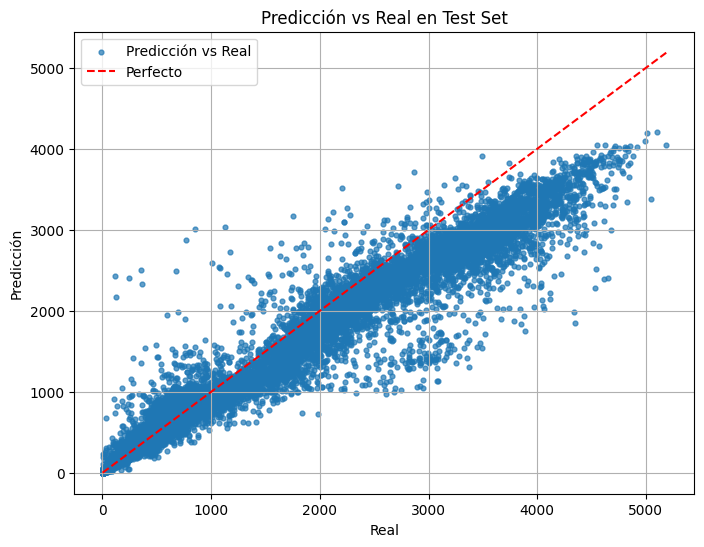

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Elige las filas a mostrar (puedes cambiar el número)
X_pred = X_test.head(90)
y_true = y_test.loc[X_pred.index]
preds = model_final.predict(X_pred, num_iteration=model_final.best_iteration)
preds = np.clip(preds, 0, None)

# DataFrame comparativo
df_resultados = pd.DataFrame({
    'Real': y_true,
    'Predicción': preds
}, index=X_pred.index)
df_resultados['Error_Absoluto'] = np.abs(df_resultados['Real'] - df_resultados['Predicción'])
df_resultados['Error_%'] = 100 * df_resultados['Error_Absoluto'] / (df_resultados['Real'] + 1e-8)  # evita división por cero

print("Comparación Real vs Predicción (primeros 50 ejemplos):")
print(df_resultados)

# Métricas globales en el test set completo
mae = mean_absolute_error(y_test, preds_test)
rmse = np.sqrt(mean_squared_error(y_test, preds_test))
mape = np.mean(np.abs((y_test - preds_test) / (y_test + 1e-8))) * 100
r2 = r2_score(y_test, preds_test)

print("\nMÉTRICAS SOBRE TODO EL TEST SET:")
print(f"MAE  (Error absoluto medio): {mae:.2f}")
print(f"RMSE (Raíz error cuadrático medio): {rmse:.2f}")
print(f"MAPE (Error porcentual absoluto medio): {mape:.2f}%")
print(f"R2   (Coeficiente de determinación): {r2:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, preds_test, s=12, alpha=0.7, label='Predicción vs Real')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfecto')
plt.xlabel('Real')
plt.ylabel('Predicción')
plt.title('Predicción vs Real en Test Set')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
import pandas as pd
import numpy as np

# Ya tienes df_resultados con las columnas 'Real', 'Predicción', 'Error_Absoluto', 'Error_%'

# 1. Las 10 con error absoluto más alto
top_errores = df_resultados.sort_values('Error_Absoluto', ascending=False).head(10)
print("\n🔴 10 Predicciones MÁS ERRADAS (mayor error absoluto):")
print(top_errores)

# 2. Las 10 con error absoluto más bajo (más acertadas, excluyendo casos donde Real=0 para evitar división por cero)
top_aciertos = df_resultados[df_resultados['Real'] > 0].sort_values('Error_Absoluto', ascending=True).head(10)
print("\n🟢 10 Predicciones MÁS ACERTADAS (menor error absoluto, Real > 0):")
print(top_aciertos)

# 6. Análisis textual
n = len(df_resultados)
mayor_error = top_errores.iloc[0]['Error_Absoluto']
menor_error = top_aciertos.iloc[0]['Error_Absoluto']

# Si quieres, exporta los resultados a csv:
# df_resultados.to_csv("comparacion_real_prediccion.csv")


🔴 10 Predicciones MÁS ERRADAS (mayor error absoluto):
        Real  Predicción  Error_Absoluto    Error_%
564969   332    5.366895      326.633105  98.383465
567030   297    5.256166      291.743834  98.230247
564968   279    5.310149      273.689851  98.096721
567031   268    5.385271      262.614729  97.990570
564967   248    5.035505      242.964495  97.969554
570860   235    5.240814      229.759186  97.769866
570859   226    5.089657      220.910343  97.747939
567029   211    5.116394      205.883606  97.575169
570858   201    4.913622      196.086378  97.555412
572919   201    5.035473      195.964527  97.494790

🟢 10 Predicciones MÁS ACERTADAS (menor error absoluto, Real > 0):
        Real  Predicción  Error_Absoluto     Error_%
576729     2    2.078094        0.078094    3.904722
564958     2    2.516213        0.516213   25.810658
567018     2    2.680142        0.680142   34.007077
577905     4    3.256506        0.743494   18.587344
576730     3    2.053536        0.946464 

## Celda 9: Importancia de variables

/tmp/ipykernel_79089/3952747130.py:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


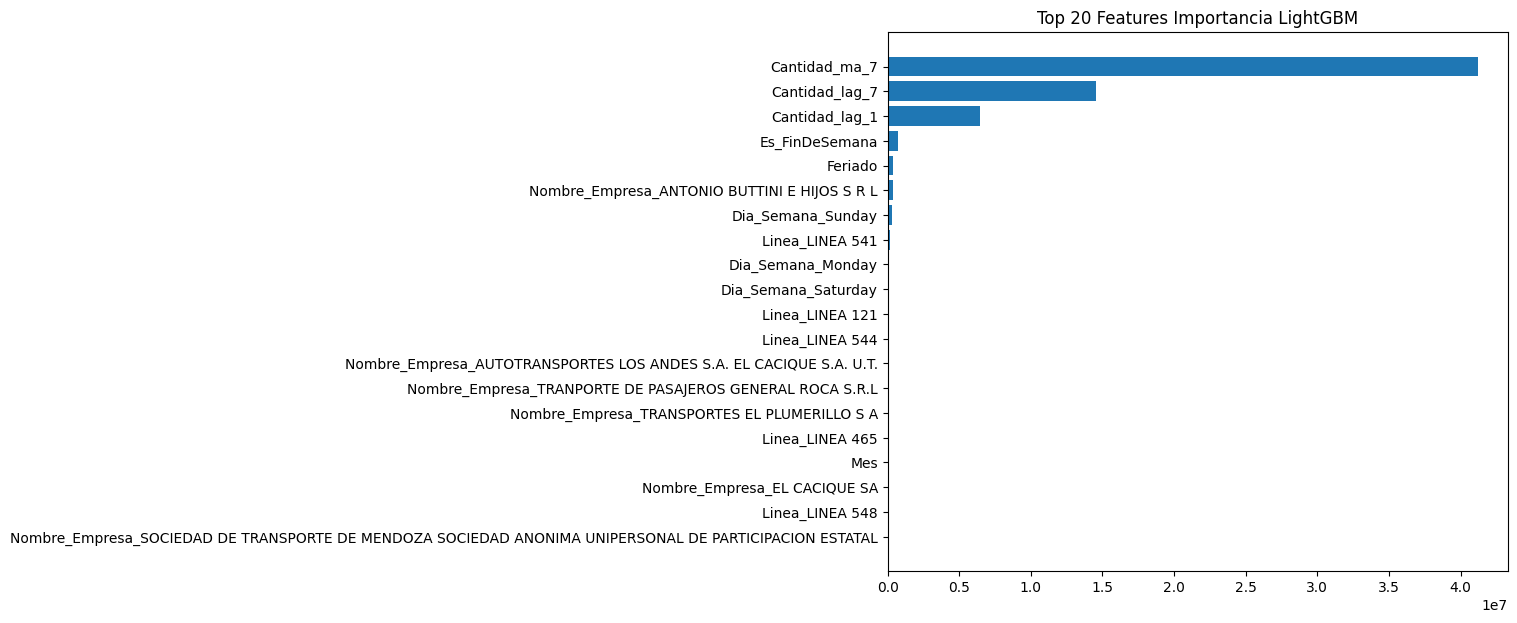

In [11]:
importances = model_final.feature_importance(importance_type='gain')
indices = np.argsort(importances)[::-1][:20]
plt.figure(figsize=(8,7))
plt.barh(np.array(features_final)[indices][::-1], importances[indices][::-1])
plt.title("Top 20 Features Importancia LightGBM")
plt.tight_layout()
plt.show()

## Celda 10: Guardar modelo y artefactos

In [12]:
joblib.dump({
    "model": model_final,
    "features": features_final,
    "params": params_final
}, "modelo_final_poisson_lgb.pkl")
print("Modelo final Poisson guardado en modelo_final_poisson_lgb.pkl")

Modelo final Poisson guardado en modelo_final_poisson_lgb.pkl


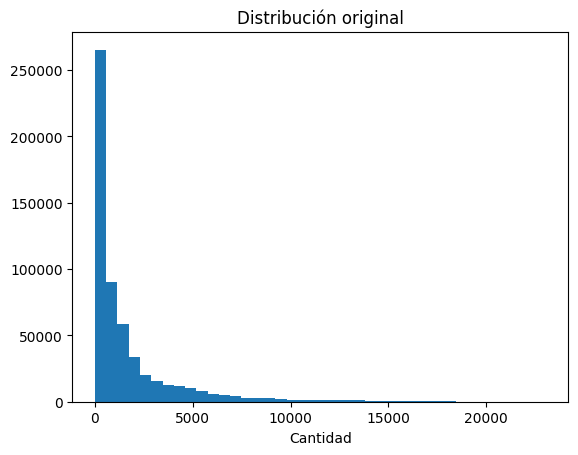

Percentil 5%: 13.00, 10%: 28.00, 20%: 90.00


In [13]:
import matplotlib.pyplot as plt

plt.hist(y_train, bins=40)
plt.title("Distribución original")
plt.xlabel("Cantidad")
plt.show()

percentiles = np.percentile(y_train, [5, 10, 20])
print(f"Percentil 5%: {percentiles[0]:.2f}, 10%: {percentiles[1]:.2f}, 20%: {percentiles[2]:.2f}")

In [14]:
print("Calculando y guardando promedios para la app...")

# Calculamos la cantidad promedio para cada Línea y Día de la Semana
promedios = df.groupby(['Linea', 'Dia_Semana'])['Cantidad'].mean().reset_index()

# También guardamos la media global por si falta alguna combinación
media_global_cantidad = df['Cantidad'].mean()

# Guardamos todo en un archivo .pkl
joblib.dump(
    {'promedios': promedios, 'media_global': media_global_cantidad}, 
    'datos_promedio.pkl'
)

print("¡Éxito! Promedios guardados en 'datos_promedio.pkl'")

Calculando y guardando promedios para la app...
¡Éxito! Promedios guardados en 'datos_promedio.pkl'


In [15]:
print("Creando el pipeline final para la app...")

# 1. Obtenemos los mejores parámetros de tu estudio de Optuna (Celda 7)
final_params = study.best_params 

# 2. Aseguramos que los parámetros fijos estén presentes
final_params['objective'] = 'regression_l1'
final_params['metric'] = 'l1'
final_params['verbosity'] = -1
final_params['seed'] = 42
final_params['n_estimators'] = 300

# 3. Creamos el Pipeline final
#    Este objeto 'full_pipeline' contiene AMBAS cosas:
#    1. El preprocesador (para imputar, escalar, etc.)
#    2. El regresor LightGBM con los mejores parámetros
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), # De tu Celda 5
    ('regressor', lgb.LGBMRegressor(**final_params)) 
])

print("Re-entrenando el pipeline completo sobre X_full[y_tr_log.index] y y_tr_log...")
# 4. Entrenamos este pipeline completo con los datos de entrenamiento FILTRADOS Y EN CRUDO
full_pipeline.fit(X_full.loc[y_tr_log.index], y_tr_log)

print("Pipeline completo entrenado.")

# 5. Guardamos el pipeline completo en un solo archivo
joblib.dump(full_pipeline, "modelo_pipeline_complejo.pkl")

print("¡Éxito! Pipeline guardado en 'modelo_pipeline_complejo.pkl'")

Creando el pipeline final para la app...
Re-entrenando el pipeline completo sobre X_full[y_tr_log.index] y y_tr_log...
Pipeline completo entrenado.
¡Éxito! Pipeline guardado en 'modelo_pipeline_complejo.pkl'
